In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import time

# Сверточная нейронная сеть

In [4]:
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from tqdm import tqdm

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [11]:
device

device(type='cuda')

In [12]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [21]:
mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

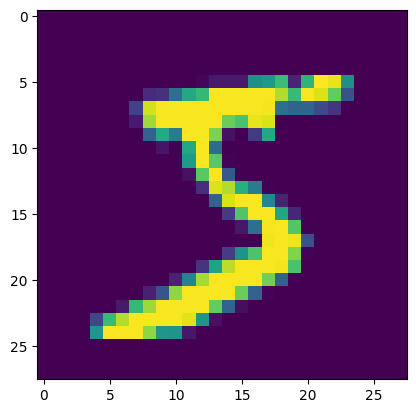

In [22]:
plt.imshow(mnist_train[0][0].squeeze(0).numpy().reshape([28, 28]))

In [23]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [27]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):
        
        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.cpu().numpy())
                    val_accuracy.extend((torch.argmax(y_pred.cpu(), dim=-1) == y_val.cpu()).numpy().tolist())
        
            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [30]:
%%time
train(model, optimizer)

100%|██████████| 157/157 [00:01<00:00, 89.80it/s]


Epoch: 0, loss: 0.09139972180128098, accuracy: 0.9736


100%|██████████| 157/157 [00:01<00:00, 83.24it/s]


Epoch: 2, loss: 0.08791783452033997, accuracy: 0.9737


100%|██████████| 157/157 [00:01<00:00, 89.45it/s]

Epoch: 4, loss: 0.0830480232834816, accuracy: 0.9746
CPU times: user 1min 1s, sys: 438 ms, total: 1min 2s
Wall time: 1min 2s


# BaseLine

In [31]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale #24x24
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон, 
    nn.Flatten(),                  # тк stride(default) = kernal_size)))))))))) надо написать было бы
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [83]:
%%time
train(model, optimizer)

100%|██████████| 157/157 [00:01<00:00, 86.47it/s]


Epoch: 0, loss: 0.051301244646310806, accuracy: 0.9825


100%|██████████| 157/157 [00:01<00:00, 83.63it/s]


Epoch: 2, loss: 0.04878440871834755, accuracy: 0.9831


100%|██████████| 157/157 [00:01<00:00, 85.16it/s]

Epoch: 4, loss: 0.04470871388912201, accuracy: 0.9843
CPU times: user 1min 5s, sys: 485 ms, total: 1min 5s
Wall time: 1min 5s


# Домашнее задание

Обучите сверточную нейронную сеть на датасете MNIST, взяв любой другой оптимизатор (кроме SGD) и любую другую функцию ошибки (кроме cross-entropy loss). Попробуйте поварьировать параметры: кол-во ядер, `kernel_size` и побить текущий бейзлайн в `0.9746`. Выведите количество обучаемых параметров.    
Какого качества удалось достичь? Попробуйте залоггировать Ваши результаты - построить графики того, как менялись метрики качества (accuracy, loss) с течением эпох, включить логгирование, сравнить результаты между собой при разных параметрах.

Любые дополнительные улучшения (как по методам, так и по коду пайплайна) приветствуются!

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

### Option first (conv 5x5 non padding))

In [59]:
hw_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,5)), # 28 * 28 -> 24x24
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2),), # -> 24x24 -> 12x12
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5)), # 12x12 -> 8x8
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2),), # 8x8 -> # 4x4
    nn.Flatten(),
    nn.Linear(4*4*32, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax()
)
hw_model.to(device)
hw_optimizer = torch.optim.Adam(hw_model.parameters(), lr=1e-3)

In [60]:
def hw_train(model, optimizer, n_epochs=8, plot = False):
    
    losses_train = []
    losses_valid = []
    accuracy_train = []
    accuracy_valid = []

    for epoch in range(n_epochs):
    
        loss_train_epoch = []
        accuracy_train_epoch = []
        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)
            loss = F.multi_margin_loss(y_pred, y_train)
            #logging
            loss_train_epoch.append(loss.cpu())
            accuracy_train_epoch.append((torch.argmax(y_pred.cpu(), dim=-1) == y_train.cpu()).numpy().mean())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        with torch.no_grad():
            losses_train.append(torch.mean(torch.tensor(loss_train_epoch)))
            accuracy_train.append(np.mean(accuracy_train_epoch))
        
        # валидация
        loss_valid_epoch = []
        accuracy_valid_epoch = []
        with torch.no_grad():
            for x_val, y_val in tqdm(val_dataloader):
                x_val, y_val = x_val.to(device), y_val.to(device)
                y_pred = model(x_val)
                loss = F.multi_margin_loss(y_pred, y_val)
                loss_valid_epoch.append(loss.cpu().numpy())
                accuracy_valid_epoch.append((torch.argmax(y_pred.cpu(), 1) == y_val.cpu()).numpy().mean())

        losses_valid.append(np.mean(loss_valid_epoch))
        accuracy_valid.append(np.mean(accuracy_valid_epoch))

        print(f'Epoch: {epoch+1}')
        print(f'Train: loss: {losses_train[-1]}, accuracy: {accuracy_train[-1]}')
        print(f'Valid: loss: {losses_valid[-1]}, accuracy: {accuracy_valid[-1]}')


    if plot:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(losses_train, label='Train')
        plt.plot(losses_valid, label='Valid')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.subplot(1, 2, 2)
        plt.plot(accuracy_train, label='Train accuracy')
        plt.plot(accuracy_valid, label='Test accuracy')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Accuracy', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.show()

100%|██████████| 157/157 [00:01<00:00, 86.94it/s]


Epoch: 1
Train: loss: 0.11898387223482132, accuracy: 0.8885261194029851
Valid: loss: 0.028628181666135788, accuracy: 0.9731289808917197


100%|██████████| 157/157 [00:01<00:00, 83.24it/s]


Epoch: 2
Train: loss: 0.027178140357136726, accuracy: 0.9740471748400853
Valid: loss: 0.02010807767510414, accuracy: 0.981687898089172


100%|██████████| 157/157 [00:01<00:00, 86.23it/s]


Epoch: 3
Train: loss: 0.020383700728416443, accuracy: 0.980360474413646
Valid: loss: 0.02256765402853489, accuracy: 0.9785031847133758


100%|██████████| 157/157 [00:01<00:00, 86.73it/s]


Epoch: 4
Train: loss: 0.01742592081427574, accuracy: 0.9831756396588486
Valid: loss: 0.014799797907471657, accuracy: 0.9860668789808917


100%|██████████| 157/157 [00:01<00:00, 87.21it/s]


Epoch: 5
Train: loss: 0.014803769066929817, accuracy: 0.9857076226012793
Valid: loss: 0.012632905505597591, accuracy: 0.9877587579617835


100%|██████████| 157/157 [00:01<00:00, 86.31it/s]


Epoch: 6
Train: loss: 0.013311308808624744, accuracy: 0.9870735607675906
Valid: loss: 0.013690371066331863, accuracy: 0.9869625796178344


100%|██████████| 157/157 [00:01<00:00, 86.80it/s]


Epoch: 7
Train: loss: 0.012406634166836739, accuracy: 0.9878065031982942
Valid: loss: 0.014816498383879662, accuracy: 0.9850716560509554


100%|██████████| 157/157 [00:01<00:00, 86.86it/s]


Epoch: 8
Train: loss: 0.012293479405343533, accuracy: 0.9878231609808102
Valid: loss: 0.015450947917997837, accuracy: 0.9848726114649682


100%|██████████| 157/157 [00:01<00:00, 87.04it/s]


Epoch: 9
Train: loss: 0.011670655570924282, accuracy: 0.9883728678038379
Valid: loss: 0.013077981770038605, accuracy: 0.987062101910828


100%|██████████| 157/157 [00:01<00:00, 83.32it/s]


Epoch: 10
Train: loss: 0.011858119629323483, accuracy: 0.988289578891258
Valid: loss: 0.012601401656866074, accuracy: 0.9874601910828026


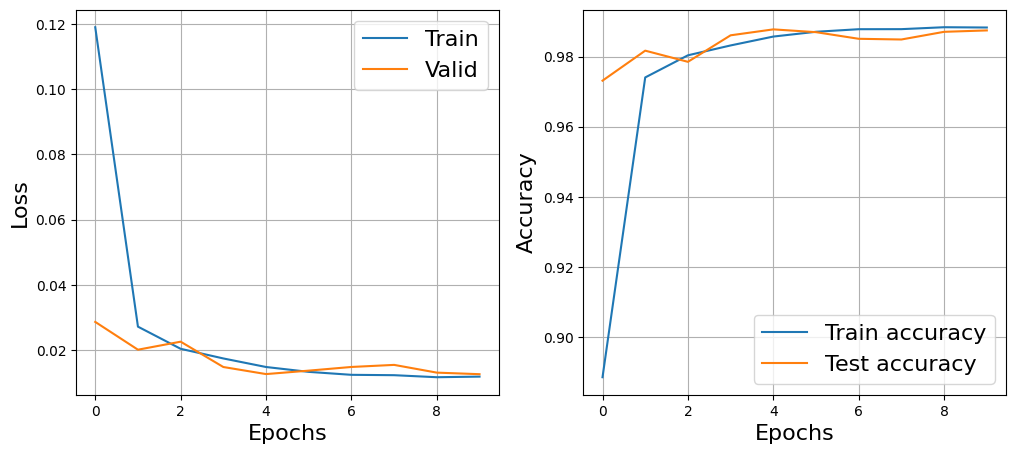

CPU times: user 2min 23s, sys: 993 ms, total: 2min 24s
Wall time: 2min 24s


In [61]:
%%time
hw_train(hw_model, hw_optimizer, plot=True, n_epochs = 10)

### Количество обучаемых параметров

In [62]:
with torch.no_grad():
    total_params = sum(p.numel() for p in hw_model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров = {total_params}")

Количество обучаемых параметров = 80202


### Option second (conv 3x3)

In [72]:
hw_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=(1,1)), # 28x28 -> 28x28
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2),), # -> 28x28 -> 14x14
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=(1,1)), # 14x14 -> 14x14
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2),), # 14x14 -> # 7x7
    nn.Flatten(),
    nn.Linear(7*7*64, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
    nn.Softmax()
)
hw_model.to(device)

hw_optimizer = torch.optim.Adam(hw_model.parameters(), lr=1e-3)

100%|██████████| 157/157 [00:01<00:00, 84.15it/s]


Epoch: 1
Train: loss: 0.018740205094218254, accuracy: 0.9812766524520256
Valid: loss: 0.01611669361591339, accuracy: 0.9837778662420382


100%|██████████| 157/157 [00:01<00:00, 84.36it/s]


Epoch: 2
Train: loss: 0.016193833202123642, accuracy: 0.9838419509594882
Valid: loss: 0.0225206408649683, accuracy: 0.9777070063694268


100%|██████████| 157/157 [00:01<00:00, 85.37it/s]


Epoch: 3
Train: loss: 0.016262223944067955, accuracy: 0.9837420042643923
Valid: loss: 0.01606396958231926, accuracy: 0.9839769108280255


100%|██████████| 157/157 [00:01<00:00, 84.52it/s]


Epoch: 4
Train: loss: 0.01393477525562048, accuracy: 0.9861240671641791
Valid: loss: 0.012399627827107906, accuracy: 0.9875597133757962


100%|██████████| 157/157 [00:01<00:00, 83.58it/s]


Epoch: 5
Train: loss: 0.013551231473684311, accuracy: 0.9864572228144989
Valid: loss: 0.012709973379969597, accuracy: 0.9873606687898089


100%|██████████| 157/157 [00:01<00:00, 84.70it/s]


Epoch: 6
Train: loss: 0.013735768385231495, accuracy: 0.986307302771855
Valid: loss: 0.014586525037884712, accuracy: 0.98546974522293


100%|██████████| 157/157 [00:02<00:00, 76.79it/s]


Epoch: 7
Train: loss: 0.014769748784601688, accuracy: 0.9853078358208955
Valid: loss: 0.024127811193466187, accuracy: 0.9759156050955414


100%|██████████| 157/157 [00:01<00:00, 84.73it/s]


Epoch: 8
Train: loss: 0.014382978901267052, accuracy: 0.9856409914712153
Valid: loss: 0.024556005373597145, accuracy: 0.9755175159235668


100%|██████████| 157/157 [00:02<00:00, 78.25it/s]


Epoch: 9
Train: loss: 0.013791882432997227, accuracy: 0.986224013859275
Valid: loss: 0.014881589449942112, accuracy: 0.9850716560509554


100%|██████████| 157/157 [00:01<00:00, 81.20it/s]


Epoch: 10
Train: loss: 0.014701902866363525, accuracy: 0.9852745202558635
Valid: loss: 0.016482757404446602, accuracy: 0.9834792993630573


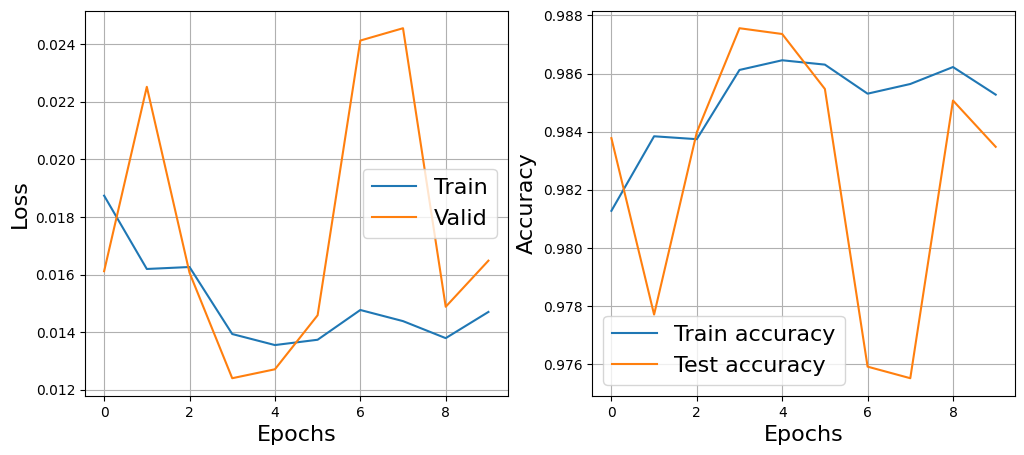

CPU times: user 2min 27s, sys: 1.07 s, total: 2min 28s
Wall time: 2min 28s


In [74]:
%%time
hw_train(hw_model, hw_optimizer, plot=True, n_epochs=10)

In [75]:
with torch.no_grad():
    total_params = sum(p.numel() for p in hw_model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров = {total_params}")

Количество обучаемых параметров = 3241354


### Option third (conv 5x5)

In [77]:
hw_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,5), stride=1, padding=2), # 28x28 -> 28x28
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)), # -> 28x28 -> 14x14
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), stride=1, padding=2), # 14x14 -> 14x14
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)), # 14x14 -> # 7x7
    nn.Flatten(),
    nn.Linear(7*7*32, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
    nn.Softmax()
)
hw_model.to(device)

hw_optimizer = torch.optim.Adam(hw_model.parameters(), lr=1e-3)

100%|██████████| 157/157 [00:01<00:00, 82.25it/s]


Epoch: 1
Train: loss: 0.0838363766670227, accuracy: 0.9202425373134329
Valid: loss: 0.03311217948794365, accuracy: 0.9680533439490446


100%|██████████| 157/157 [00:02<00:00, 76.95it/s]


Epoch: 2
Train: loss: 0.02497260272502899, accuracy: 0.9753964552238806
Valid: loss: 0.022175999358296394, accuracy: 0.9786027070063694


100%|██████████| 157/157 [00:01<00:00, 79.56it/s]


Epoch: 3
Train: loss: 0.0218800101429224, accuracy: 0.978394856076759
Valid: loss: 0.019578292965888977, accuracy: 0.9804936305732485


100%|██████████| 157/157 [00:01<00:00, 84.30it/s]


Epoch: 4
Train: loss: 0.02184753306210041, accuracy: 0.978394856076759
Valid: loss: 0.045170728117227554, accuracy: 0.955015923566879


100%|██████████| 157/157 [00:01<00:00, 84.82it/s]


Epoch: 5
Train: loss: 0.02089736983180046, accuracy: 0.9792277452025586
Valid: loss: 0.022186147049069405, accuracy: 0.9776074840764332


100%|██████████| 157/157 [00:01<00:00, 82.32it/s]


Epoch: 6
Train: loss: 0.01876872591674328, accuracy: 0.9812433368869936
Valid: loss: 0.01613731123507023, accuracy: 0.9838773885350318


100%|██████████| 157/157 [00:01<00:00, 82.30it/s]


Epoch: 7
Train: loss: 0.01777956821024418, accuracy: 0.9821595149253731
Valid: loss: 0.01268311869353056, accuracy: 0.9873606687898089


100%|██████████| 157/157 [00:01<00:00, 80.46it/s]


Epoch: 8
Train: loss: 0.020213207229971886, accuracy: 0.9798274253731343
Valid: loss: 0.02092154324054718, accuracy: 0.9789012738853503


100%|██████████| 157/157 [00:01<00:00, 81.04it/s]


Epoch: 9
Train: loss: 0.018429458141326904, accuracy: 0.9815098614072495
Valid: loss: 0.022629309445619583, accuracy: 0.9774084394904459


100%|██████████| 157/157 [00:02<00:00, 78.46it/s]


Epoch: 10
Train: loss: 0.017340106889605522, accuracy: 0.9826425906183369
Valid: loss: 0.017126858234405518, accuracy: 0.9829816878980892


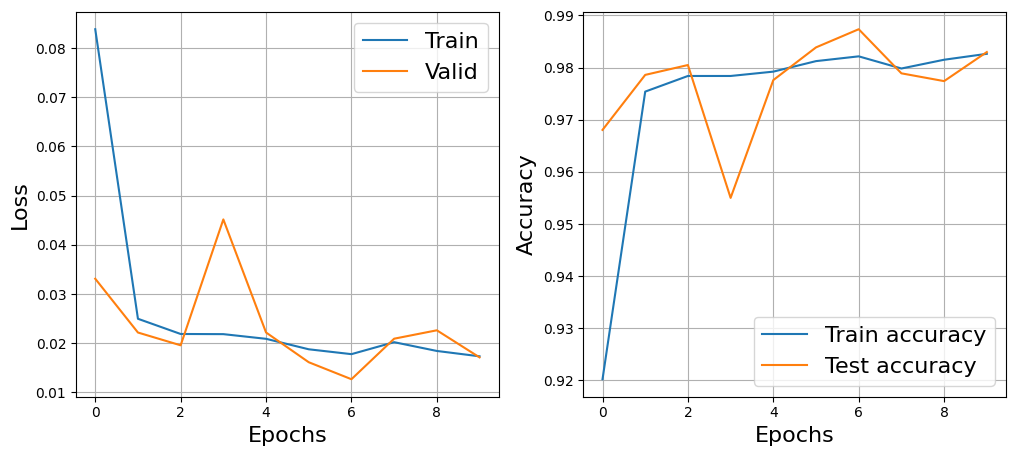

CPU times: user 2min 31s, sys: 1.1 s, total: 2min 32s
Wall time: 2min 32s


In [78]:
%%time
hw_train(hw_model, hw_optimizer, plot=True, n_epochs=10)

In [79]:
with torch.no_grad():
    total_params = sum(p.numel() for p in hw_model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров = {total_params}")

Количество обучаемых параметров = 1630154


### Option 4th (conv 5x5) with dropout)

In [80]:
hw_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,5), stride=1, padding=2), # 28x28 -> 28x28
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)), # -> 28x28 -> 14x14
    
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), stride=1, padding=2), # 14x14 -> 14x14
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)), # 14x14 -> # 7x7
    
    nn.Flatten(),
    nn.Linear(7*7*32, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(1024, 10),
    nn.Softmax()
)
hw_model.to(device)

hw_optimizer = torch.optim.Adam(hw_model.parameters(), lr=1e-3)

100%|██████████| 157/157 [00:01<00:00, 81.45it/s]


Epoch: 1
Train: loss: 0.11112967878580093, accuracy: 0.8935567697228145
Valid: loss: 0.03507732227444649, accuracy: 0.9659633757961783


100%|██████████| 157/157 [00:01<00:00, 86.03it/s]


Epoch: 2
Train: loss: 0.02909359335899353, accuracy: 0.9714652185501066
Valid: loss: 0.02509366348385811, accuracy: 0.9758160828025477


100%|██████████| 157/157 [00:01<00:00, 80.32it/s]


Epoch: 3
Train: loss: 0.024044139310717583, accuracy: 0.9762626599147122
Valid: loss: 0.018252594396471977, accuracy: 0.9818869426751592


100%|██████████| 157/157 [00:01<00:00, 84.60it/s]


Epoch: 4
Train: loss: 0.023921575397253036, accuracy: 0.9760960820895522
Valid: loss: 0.026976561173796654, accuracy: 0.9736265923566879


100%|██████████| 157/157 [00:01<00:00, 80.50it/s]


Epoch: 5
Train: loss: 0.023448770865797997, accuracy: 0.9765625
Valid: loss: 0.02055004984140396, accuracy: 0.9792993630573248


100%|██████████| 157/157 [00:01<00:00, 84.42it/s]


Epoch: 6
Train: loss: 0.02183542586863041, accuracy: 0.9782116204690832
Valid: loss: 0.017079820856451988, accuracy: 0.9826831210191083


100%|██████████| 157/157 [00:01<00:00, 82.17it/s]


Epoch: 7
Train: loss: 0.01967921480536461, accuracy: 0.9803271588486141
Valid: loss: 0.01622970774769783, accuracy: 0.9839769108280255


100%|██████████| 157/157 [00:01<00:00, 86.08it/s]


Epoch: 8
Train: loss: 0.01993369124829769, accuracy: 0.9801106076759062
Valid: loss: 0.028620798140764236, accuracy: 0.9716361464968153


100%|██████████| 157/157 [00:02<00:00, 75.70it/s]


Epoch: 9
Train: loss: 0.02273702062666416, accuracy: 0.9772621268656716
Valid: loss: 0.017759665846824646, accuracy: 0.9821855095541401


100%|██████████| 157/157 [00:01<00:00, 84.81it/s]


Epoch: 10
Train: loss: 0.020251991227269173, accuracy: 0.9797607942430704
Valid: loss: 0.01886729523539543, accuracy: 0.9810907643312102


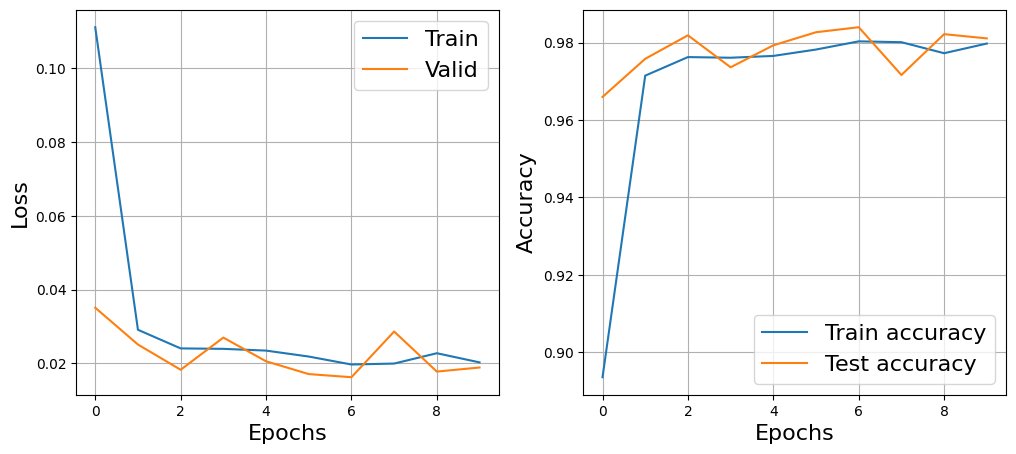

CPU times: user 2min 26s, sys: 1.04 s, total: 2min 28s
Wall time: 2min 28s


In [81]:
%%time
hw_train(hw_model, hw_optimizer, plot=True, n_epochs=10)

In [82]:
with torch.no_grad():
    total_params = sum(p.numel() for p in hw_model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров = {total_params}")

Количество обучаемых параметров = 1630154


### 3 conv layers

In [89]:
hw_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), stride=1, padding=1), # 28x28 -> 28x28
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)), # -> 28x28 -> 14x14
    
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=1, padding=1), # 14x14 -> 14x14
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)), # 14x14 -> # 7x7

    
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), stride=1), # 7x7 -> 7x7
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=1), # 7x7 -> # 6x6
    
    nn.Flatten(),
    nn.Linear(6*6*64, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(1024, 10),
    nn.Softmax()
)
hw_model.to(device)

hw_optimizer = torch.optim.Adam(hw_model.parameters(), lr=1e-3)

100%|██████████| 157/157 [00:02<00:00, 77.13it/s]


Epoch: 1
Train: loss: 0.16342215240001678, accuracy: 0.8410514392324094
Valid: loss: 0.046884406358003616, accuracy: 0.9544187898089171


100%|██████████| 157/157 [00:01<00:00, 83.02it/s]


Epoch: 2
Train: loss: 0.04115060344338417, accuracy: 0.9592550639658849
Valid: loss: 0.03443428501486778, accuracy: 0.9657643312101911


100%|██████████| 157/157 [00:01<00:00, 81.15it/s]


Epoch: 3
Train: loss: 0.033476922661066055, accuracy: 0.966834355010661
Valid: loss: 0.03131461143493652, accuracy: 0.9690485668789809


100%|██████████| 157/157 [00:01<00:00, 84.54it/s]


Epoch: 4
Train: loss: 0.0311236884444952, accuracy: 0.9691331289978679
Valid: loss: 0.025041384622454643, accuracy: 0.9745222929936306


100%|██████████| 157/157 [00:01<00:00, 81.47it/s]


Epoch: 5
Train: loss: 0.029560580849647522, accuracy: 0.970632329424307
Valid: loss: 0.030382059514522552, accuracy: 0.9694466560509554


100%|██████████| 157/157 [00:01<00:00, 84.44it/s]


Epoch: 6
Train: loss: 0.030661728233098984, accuracy: 0.9694163113006397
Valid: loss: 0.029981642961502075, accuracy: 0.9702428343949044


100%|██████████| 157/157 [00:02<00:00, 77.35it/s]


Epoch: 7
Train: loss: 0.029967376962304115, accuracy: 0.9699493603411514
Valid: loss: 0.027379335835576057, accuracy: 0.9726313694267515


100%|██████████| 157/157 [00:01<00:00, 85.22it/s]


Epoch: 8
Train: loss: 0.030923355370759964, accuracy: 0.9689998667377399
Valid: loss: 0.022375227883458138, accuracy: 0.9776074840764332


100%|██████████| 157/157 [00:01<00:00, 82.49it/s]


Epoch: 9
Train: loss: 0.029303941875696182, accuracy: 0.970715618336887
Valid: loss: 0.023890143260359764, accuracy: 0.9761146496815286


100%|██████████| 157/157 [00:01<00:00, 83.97it/s]


Epoch: 10
Train: loss: 0.02850402519106865, accuracy: 0.9714985341151386
Valid: loss: 0.027753280475735664, accuracy: 0.9721337579617835


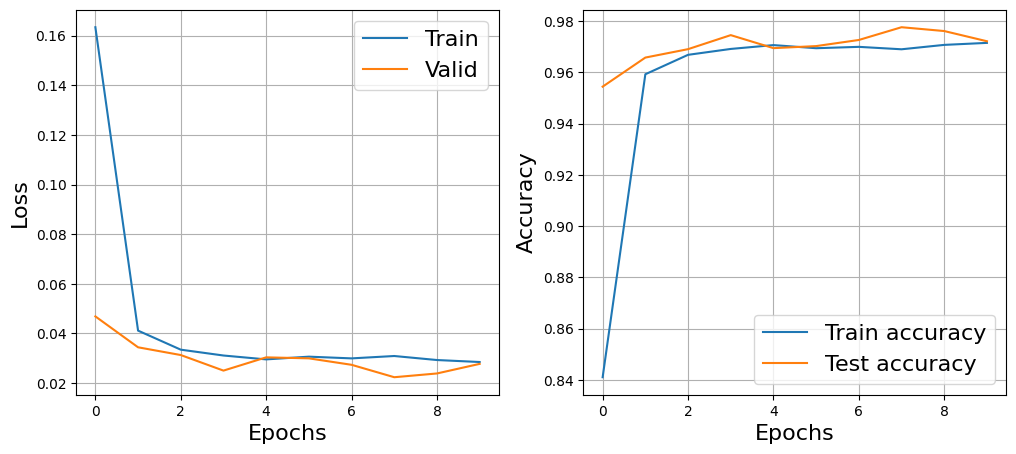

CPU times: user 2min 29s, sys: 1.03 s, total: 2min 30s
Wall time: 2min 30s


In [90]:
%%time
hw_train(hw_model, hw_optimizer, plot=True, n_epochs=10)

In [91]:
with torch.no_grad():
    total_params = sum(p.numel() for p in hw_model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров = {total_params}")

Количество обучаемых параметров = 2377482


### 1 conv layers

In [92]:
hw_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=1, padding=2), # 28x28 -> 28x28
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(4,4)), # -> 28x28 -> 7x7
    
    nn.Flatten(),
    nn.Linear(7*7*32, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(1024, 10),
    nn.Softmax()
)
hw_model.to(device)

hw_optimizer = torch.optim.Adam(hw_model.parameters(), lr=1e-3)

100%|██████████| 157/157 [00:01<00:00, 82.02it/s]


Epoch: 1
Train: loss: 0.0933791771531105, accuracy: 0.9126299307036247
Valid: loss: 0.04000486433506012, accuracy: 0.9618829617834395


100%|██████████| 157/157 [00:01<00:00, 83.35it/s]


Epoch: 2
Train: loss: 0.039003100246191025, accuracy: 0.9624866737739872
Valid: loss: 0.03542976453900337, accuracy: 0.9652667197452229


100%|██████████| 157/157 [00:02<00:00, 76.37it/s]


Epoch: 3
Train: loss: 0.030827896669507027, accuracy: 0.9701825692963753
Valid: loss: 0.028973830863833427, accuracy: 0.9720342356687898


100%|██████████| 157/157 [00:01<00:00, 83.17it/s]


Epoch: 4
Train: loss: 0.02629861794412136, accuracy: 0.9745135927505331
Valid: loss: 0.0213799849152565, accuracy: 0.9791003184713376


100%|██████████| 157/157 [00:01<00:00, 78.68it/s]


Epoch: 5
Train: loss: 0.023750843480229378, accuracy: 0.9769789445628998
Valid: loss: 0.018992198631167412, accuracy: 0.9808917197452229


100%|██████████| 157/157 [00:01<00:00, 84.91it/s]


Epoch: 6
Train: loss: 0.021981725469231606, accuracy: 0.978444829424307
Valid: loss: 0.019809667021036148, accuracy: 0.9808917197452229


100%|██████████| 157/157 [00:01<00:00, 79.57it/s]


Epoch: 7
Train: loss: 0.018806694075465202, accuracy: 0.9817264125799574
Valid: loss: 0.020991941913962364, accuracy: 0.9791003184713376


100%|██████████| 157/157 [00:01<00:00, 80.59it/s]


Epoch: 8
Train: loss: 0.01895073615014553, accuracy: 0.9813765991471215
Valid: loss: 0.01903534308075905, accuracy: 0.9810907643312102


100%|██████████| 157/157 [00:01<00:00, 83.86it/s]


Epoch: 9
Train: loss: 0.017352169379591942, accuracy: 0.9830590351812367
Valid: loss: 0.01758842170238495, accuracy: 0.9826831210191083


100%|██████████| 157/157 [00:01<00:00, 81.18it/s]


Epoch: 10
Train: loss: 0.01595473103225231, accuracy: 0.9843416844349681
Valid: loss: 0.019382251426577568, accuracy: 0.9803941082802548


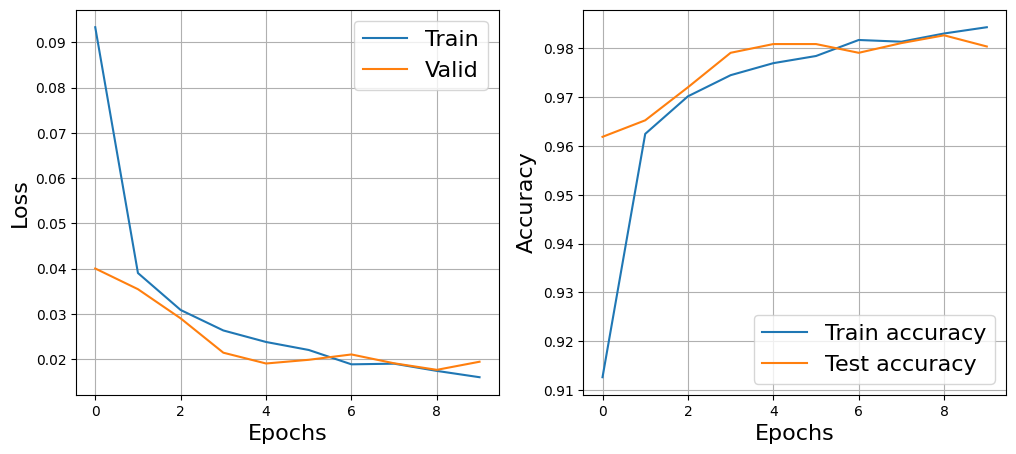

CPU times: user 2min 27s, sys: 1.03 s, total: 2min 28s
Wall time: 2min 28s


In [93]:
%%time
hw_train(hw_model, hw_optimizer, plot=True, n_epochs=10)

In [94]:
with torch.no_grad():
    total_params = sum(p.numel() for p in hw_model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров = {total_params}")

Количество обучаемых параметров = 1617738


# **Выводы**

***Кол-во conv слоёв***: Наилучшие результаты показала NN с 2 свёрточными слоями, увеличение до 3 или использование 1 слоя не показало улучшение результата. Это может быть связано с тем, что с 3 слоями кол-во обучаемых параметров становится слишком большим - нейронная сеть из-за большой разряженности не может уловить зависимости, т.к. MNIST не очень "богатый" датасет. В случае с 1 слоев, всё наоборот - из-за малого кол-ва обучаемых параметров сеть не выучивает закономерности (однако, если хорошо подобрать гипперпараметры то и 1 слой показывает примерно те же результаты что и два слоя). 

***Размер ядра***: При двухслоойной архитектуре ядро 3x3 и ядро 5x5 показывает приблизительно одинаковые резульататы

***Наилучший результат***: Наилучший результат получился при первой(*Option first (conv 5x5 non padding))*) архитектуре с 80202 обучаемыми параметрами. Возможно в других вариантах соотношение кол-во параметров/сложность модели были хуже, чем в этом, поэтому получились такие результаты

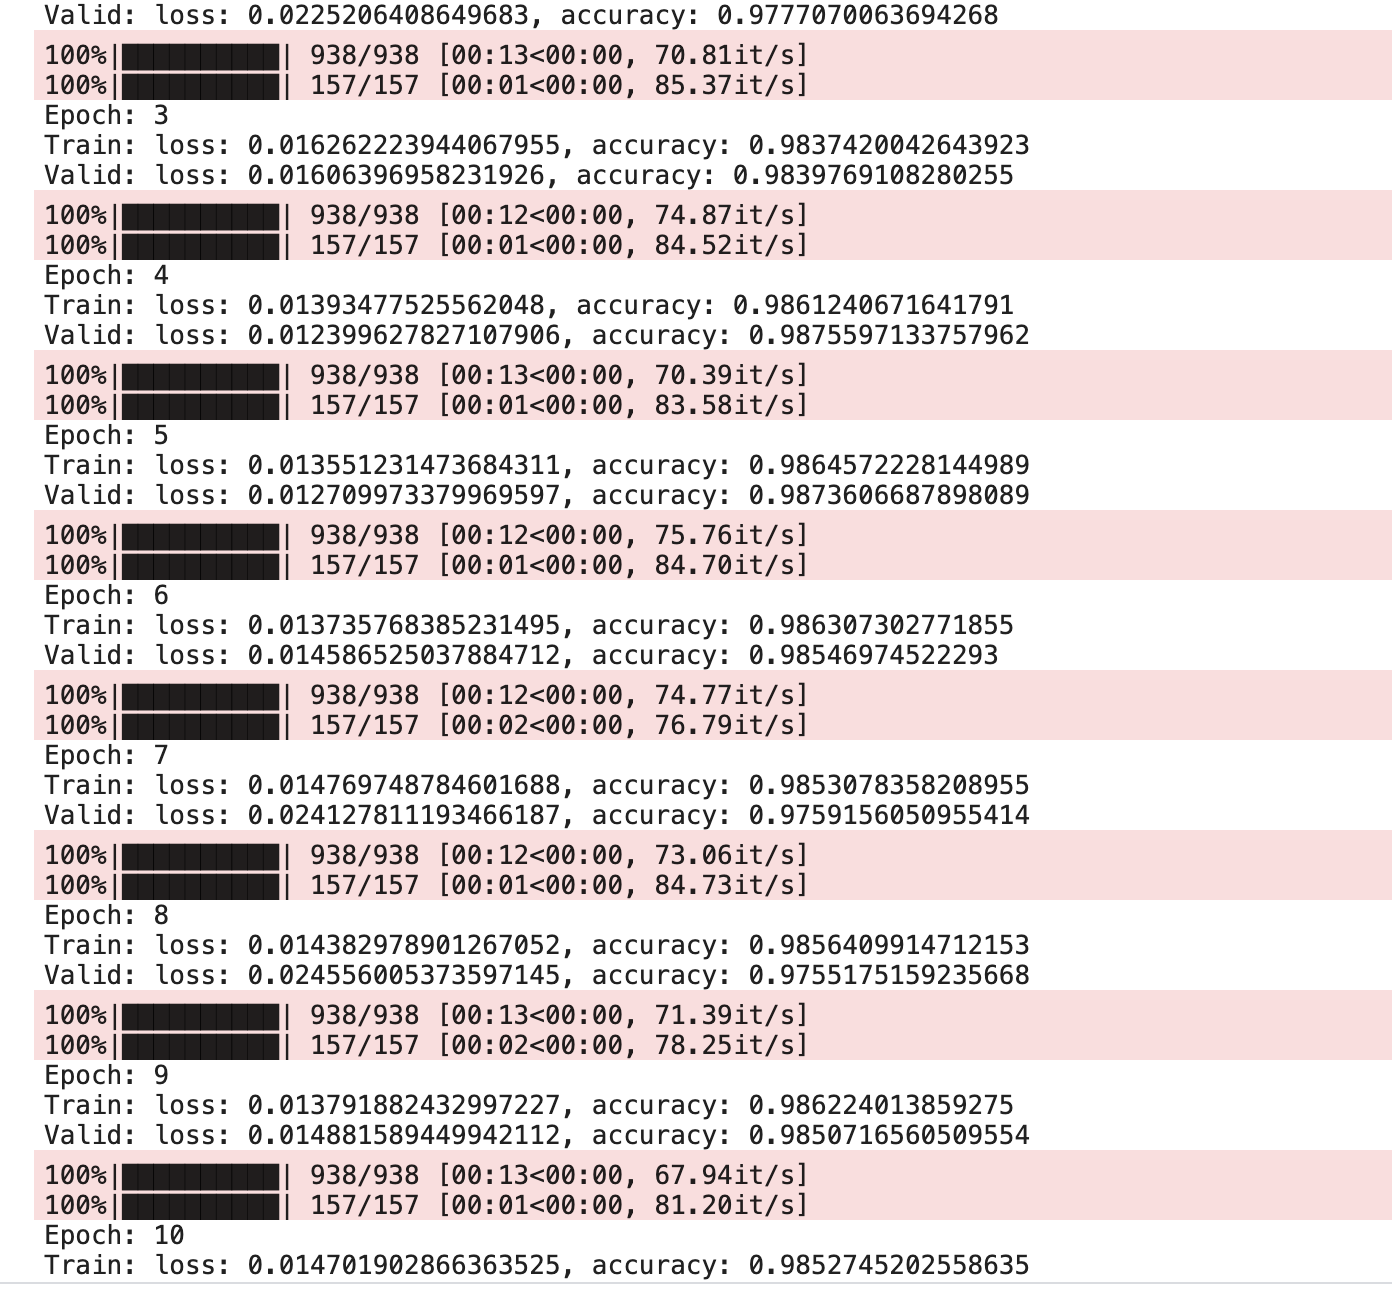